In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression

In [8]:
%load_ext autoreload
%autoreload 2
from functions import loaddata, MACD, RSI
from simple_model import stock_prediction_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font size="6"> Abstract: <font>

Problem:

Goals:

Hypothesis:

Feature Types:


<font size="6"> Data Collection: <font> 



Arguably the hardest part of this project was collecting the data, transferring it into a file format that is easily accessible, and then creating functions that can be easily and functionally used. Our data set is made up of 4,752 companies in China. Each companies has 21 years worth of daily data for 28 different metrics. In total that is over 670,000,000 data points. We saved each of the different metrics as CSV files composed of DataFrames holding all the values for each company over 21 years. All of the raw data was generously provided to us by Professor Scott Smallwood, who runs a quantitative trading fund. His fund paid for this data through a stock broker agency. Below we will explore some of the functions we used to access the data and transform it into useful features.

<font size="6"> Functions/Indicators: <font> 

https://github.com/Astro2024/Astro2024.github.io/blob/main/posts/final-project/functions.py

The first function in our function.py file is called "loaddata". As parameters it takes the shortened name of our of our companies metrics, a start date, and an end date. After we feed it the inputs it opens up the designated CSV file and creates/returns a dataframe to store all of the data. This was probably the most used function in our entire project.

In [1]:
def loaddata(name: str, start_date = 20100104, end_date = 20211231):
    dates = pd.read_csv("Data_Files/dates.csv", header=None)
    data = pd.read_csv("Data_Files/"+  name + ".csv", header=None, names=dates.T.values.tolist()[0])

    return data.loc[:, start_date:end_date]

The next function we built out transforms price data into a MACD indicator. As we discussed above, the moving average convergence/divergence indicator is on of the most popular indicators in the world for trading. This function takes in price data, a specified length for the long and short exponential moving average, and the period length for an exponential moving average of the difference between our long and short ema curves. Fortunately, pandas DataFrames have a built in exponential moving average function, so the majority of the MACD is easy to calculate. We will show how the MACD indicator can be used as an indicator for stock trading. 

If anyone is interested in learning more about this stock indicator I have attached a link to a basic overview: https://www.investopedia.com/terms/m/macd.asp 

In [4]:
def MACD(data: pd.DataFrame, ema_long: int, ema_short: int, signal_length: int):
    long = data.ewm(span=ema_long, ignore_na=True).mean()
    short = data.ewm(span=ema_short, ignore_na=True).mean()
    macd = short - long
    signal = macd.ewm(span=signal_length, ignore_na=True).mean()

    return macd - signal

The last function we use in our model is called the Relative Strength Indicator or RSI for short. This indicator measures whether a stock is "overbought" or "oversold" allow traditional trader gain insights into incoming trends in the market. Because of the format of our data, this version of rsi is slightly modified to allow for a shorter time frame of data, however, because of this the first 15-20 RSI values might not the most significant. In fact, most RSI indicators take a while to "warm up" before there prediction is considered "good". For more information about the RSI indicator you can read the article from this link: https://www.investopedia.com/terms/r/rsi.asp 

In [ ]:
def RSI(data: pd.DataFrame, period: int):
    rsi_values = []
    cleaned = data
    av_gain_array = []
    av_loss_array = []
    for i in range(len(cleaned)):
        if i + 1 < period:
            batch = cleaned.iloc[:i+1].dropna()
            positives = batch[batch >= 0]
            negatives = batch[batch < 0]
            av_gain_array.append((positives.sum()+.001) / (i+1))        
            av_loss_array.append(((-1*negatives.sum())+.001) / (i+1))
        else:
            current_move = cleaned.iloc[i]
            pos = current_move if current_move >= 0 else 0
            neg = -1*(current_move) if current_move < 0 else 0
            av_gain_array.append(((av_gain_array[i-1] * (period-1)) + pos)/period)
            av_loss_array.append(((av_loss_array[i-1] * (period-1)) + neg)/period)
    RS = np.array(av_gain_array) / np.array(av_loss_array)
    return 100 - (100/(1+RS))

<font size="5"> MACD And RSI In Use: <font>

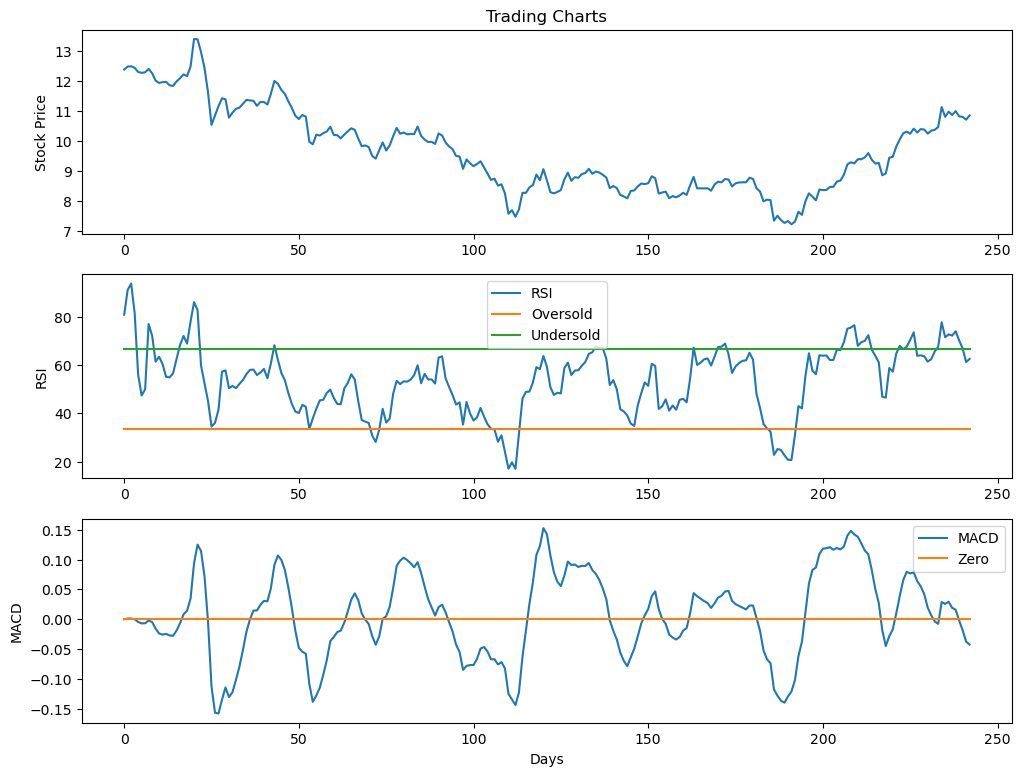

In [13]:
#Randomly selected company
comp = 1003
#Get price data
temp = loaddata("r_ti2", 20180101, 20190101)
temp1 = loaddata("mid_close", 20180101, 20190101)

test1 = temp1.iloc[comp].dropna().ewm(span=12, ignore_na=True).mean()
test2 = temp1.iloc[comp].dropna().ewm(span=26, ignore_na=True).mean()
macd = test1 - test2
signal = macd.ewm(span=9, ignore_na=True).mean()
xzero = [0 for i in range(len(macd))]
rsi = RSI(temp.iloc[comp], 12)

fig, ax = plt.subplots(3, figsize = (12,9))
ax[0].plot(np.array(temp1.iloc[comp].dropna()))
ax[0].set_title("Trading Charts")
ax[0].set_ylabel("Stock Price")
ax[1].plot(rsi, label="RSI")
ax[1].plot([33.3 for i in range(len(rsi))], label="Oversold")
ax[1].plot([66.6 for i in range(len(rsi))], label="Undersold")
ax[1].set_ylabel("RSI")
ax[1].legend()
ax[2].plot(np.array(MACD(temp1.iloc[comp],26,12,9)), label="MACD")
ax[2].plot(np.array(xzero), label="Zero")
ax[2].set_ylabel("MACD")
ax[2].set_xlabel("Days")
ax[2].legend()

<font size="6"> Baseline Model: <font> 

In order to try an evaluate the various models we are going to explore later in this blog post we must first set a base line to compare our results to. To do this we will take our MACD indicator, apply it to every company over a set period of time, and buy/sell the stock depending on if the MACD is positive or negative.

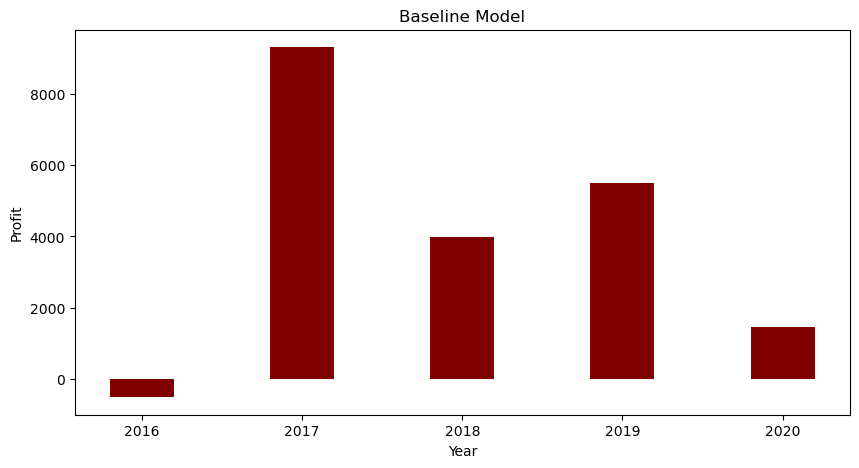

In [29]:
training_starts = [20160101,20170101,20180101,20190101,20200101]
training_ends = [20170101,20180101,20190101,20200101,20210101]
years = [2016,2017,2018,2019,2020]
baseline_profits = []

for i in range(len(years)):
    total_signal = 0
    close_data = loaddata("mid_close", training_starts[i], training_ends[i])
    open_data = loaddata("mid_open", training_starts[i], training_ends[i])
    for i in range(4752):
        doit = MACD(close_data.iloc[i], 26, 12, 9)
        close_price = close_data.iloc[i]
        open_price = open_data.iloc[i]
        
        remove = pd.DataFrame({"X": doit, "X1": close_price, "X2": open_price}).dropna()

        mac = np.array(remove["X"])
        close = np.array(remove["X1"])
        open1 = np.array(remove["X2"])

        sum_signal = 0
        sum_zero = 0
        for j in range(len(mac)-1):
            #Short
            #print(buy_signal_index[j]+1)
            if mac[j] < 0:
                sum_signal += open1[j+1] - close[j+1]
            #Long
            else:
                sum_signal += close[j+1] - open1[j+1]

        #print("Traditional Signal: ", sum_signal)
        total_signal += sum_signal
    baseline_profits.append(total_signal)

fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.bar(years, baseline_profits, color ='maroon', width = 0.4)
plt.xlabel("Year")
plt.ylabel("Profit")
plt.title("Baseline Model")
plt.show()

<font size="6"> Our Model: <font> 

After developing a baseline model along with a series of useful functions and indicators we can start to build out our initial models using the indicators/features discussed above. Below we will walk through the model function and explore how its functionality changes depending on it parameters. 

Link to code: https://github.com/Astro2024/Astro2024.github.io/blob/main/posts/final-project/simple_model.py

<font size="5"> Helper Functions: <font>

Before we even reach the model we need to define two functions. The first records whether or not a value is positive, negative, or zero. We use this function to create our labels for the Logistic Regression. The second function returns the ln value of an element of an array. We need to define this function to reduce the volume, which tends to be vary large, down to log space so the models weights are more manageable and less likely to have floating point errors.

In [8]:
def sign(x):
    if x > 0:
        return 1
    elif x < 0:
        return 0
    else:
        return 2
    
def my_log(x):
    if x != 0 and np.isnan(x) == False:
        return np.log(x)
    else:
        return x

<font size="5"> Parameters <font>

Our model function takes 8 different parameters:

In [ ]:
stock_prediction_model(
        training_period_start = 20180101, 
        training_period_end = 20190101,
        testing_period_start = 20190101,
        testing_period_end = 20200101,
        total_market = True,
        individual = False,
        polynomial_features = 1,
        print_results = True
    )

The first four are pretty self explanatory. They are int values, formatted as "year + month + day", that define our training period and testing period. In the example above we would be training the model on the entirety of 2018 then evaluating the models success on the entirety of 2019. 

The next three parameters define what type of model we want. "total_market" decides whether the model will be looking at every company in the market (True) or just the "low volatility" companies (False). "individual" lets us choose whether we want multiple models trained and evaluated individually on each company, or a singular model trained across what ever market we specified in the previous parameter. "polynomial_features" defines the degree of polynomial feature mapping for our feature matrix.

The last parameter is solely for practical use in this blog post. It toggles whether the function will print out results or return them.

<font size="5"> Initializing data: <font>

Now that we have an understanding of the parameters, let's move our attention to the first section of code where we initialize all of our data. The comments in the following code explains what each line is/what it is used for.

In [ ]:
#Creates our Polynomial feature mapping function of degree "polynomial_features"
poly = PolynomialFeatures(polynomial_features) # type: ignore
#Initializes a list we will use to record the profit/loss of each company
total = []
#Initializes a list we use to concatenate the feature matrixes of all our companies together
total1 = []
#Initializes a list we use to record the accuracy of our model to predict the correct label for each company
chk = []
#Initializes a list we use to record the accuracy of our model to predict the correct price movement for each company
test = []
#Initializes a list we use to record how many label are actual correct in our data
pls = []
#Initializes a variable that will hold the indices of the companies we want to train and test our model on
indices = []

""" Test Data """
#Loads the intraday market neutral residual returns for specified training time period
rtxm_ti2 = loaddata("rtxm_ti2", training_period_start, training_period_end)# type: ignore
#Loads the overnight market neutral residual returns for specified training time period
rtxm_ti1 = loaddata("rtxm_ti1", training_period_start, training_period_end)# type: ignore
#Loads the intraday raw residual returns for specified training time period
r_ti2 = loaddata("r_ti2", training_period_start, training_period_end)# type: ignore
#Loads the intraday volume for specified training time period
volume = loaddata("volall_day", training_period_start, training_period_end)# type: ignore
#Loads the daily market close price for specified training time period
mid_close = loaddata("mid_close", training_period_start, training_period_end)# type: ignore
#Loads the risk/volatility  for specified training time period (predicted values so it is not cheating to use in model)
risk = loaddata("bfast_totrisk", training_period_start, training_period_end)# type: ignore

""" Training Data """
#Loads the intraday market neutral residual returns for specified testing time period
rtxm_ti2_test = loaddata("rtxm_ti2", testing_period_start, testing_period_end)# type: ignore
#Loads the overnight market neutral residual returns for specified testing time period
rtxm_ti1_test = loaddata("rtxm_ti1", testing_period_start, testing_period_end)# type: ignore
#Loads the intraday raw residual returns for specified testing time period
r_ti2_test = loaddata("r_ti2", testing_period_start, testing_period_end)# type: ignore
#Loads the overnight volume for specified testing time period
volume_test = loaddata("volall_day", testing_period_start, testing_period_end)# type: ignore
#Loads the daily market close price for specified testing time period
mid_close_test = loaddata("mid_close", testing_period_start, testing_period_end)# type: ignore
#Loads the daily market open price for specified testing time period
mid_open_test = loaddata("mid_open", testing_period_start, testing_period_end)# type: ignore

""" Defines indices of companies in specified market """
#Get all indices
if total_market == True:# type: ignore
    indices = range(mid_close.shape[0])
#Get only low volatility indices
elif total_market == False:# type: ignore
    average_risk = risk.mean(axis=1, skipna=True).dropna()
    bottom_third = average_risk.quantile(.3333)
    indices = average_risk[average_risk < bottom_third].index


<font size="5"> Single Model: <font>

<font size="4"> Data Rransformation and Training: <font>

The next part of our function transforms our "raw" data into features we want to use in order to predict whether the raw residual return will move up our down. The before the polynomial transformation the five features we are using for the model are yesterday's intraday market neutral residual returns, last night's market neutral residual returns, yesterday's volume mapped to log space, a RSI indicator, and a MACD indicator.

In [ ]:
""" TRAINING DATA AND MODEL """
#Iterates though every company in the designated market
#4752 companies if total_market = True, around 1200-1300 companies if total_market = False
#Total Market vs. Low Volatility 
for i in indices:
    #Gets the daily closing price
    price_i = mid_close.iloc[i]
    #Gets the overnight residual returns minus market influence
    overnight_i = rtxm_ti1.iloc[i, 1:]
    #Gets yesterday's intraday residual returns minus market influence
    intraday_i = rtxm_ti2.iloc[i,:-1]
    #Gets yesterday's volume and maps it to log space
    volume_i = volume.iloc[i, :-1].map(lambda x: my_log(x), na_action="ignore")
    #Calculates the RSI indicator
    rsi_12 = RSI(rtxm_ti2.iloc[i], 12)[:-1]
    #Calculates the MACD indicator
    macd_26_12_9 = MACD(price_i, 26, 12, 9)[:-1]
    #Creates our labels for whether the raw residual returns will go down, up, or stay the same
    y = r_ti2.iloc[i, 1:].map(lambda x: sign(x), na_action="ignore")
    #Creates a dataframe for the data and drops all days where we do not have sufficient data
    data = {'X1': np.array(overnight_i), 'X2': np.array(intraday_i), "X3": np.array(volume_i), 
            "X4": np.array(rsi_12), "X5": np.array(macd_26_12_9),
            "Y": np.array(y)}
    data_train = pd.DataFrame(data)
    new_train = data_train.dropna()
    #Threshold of 100 trading days in a year for the company to be trained on.
    if new_train.shape[0] > 100:
        total1.append(new_train)
#Concatenates all the companies data together into a dataframe for easy shuffling and training
final_df = pd.concat(total1)

#Initialize our model with 1000 epochs for training
LR = LogisticRegression(max_iter=1000)
#Randomize our data (keeps x and y together but shuffles rows)
temp = final_df.sample(frac=1).reset_index(drop=True)
#Set aside our predictor variable and labels
final_x_training = temp[["X1","X2","X3","X4","X5"]]
final_y_training = temp[["Y"]]
#Creates a polynomial transformation of our feature matrix
attempt = poly.fit_transform(final_x_training)
#Fit our model to the data
LR.fit(attempt, np.ravel(final_y_training))

<font size="4"> Model Testing: <font>

The code for testing the model is very similar to the training code, because we need to transform the "raw" data again. One thing you will notice in the code above and below is that we only train and test on companies that have more than 100 valid days of data. This is to ensure we are only adding data that might be representative of the market in that year.

In [ ]:
""" TESTING DATA AND MODEL """
#Check shape of data and makes sure there is no cheating
if total_market == True:# type: ignore
    indices = range(mid_close_test.shape[0])
elif total_market == False:# type: ignore
    average_risk = risk.mean(axis=1, skipna=True).dropna()
    bottom_third = average_risk.quantile(.3333)
    indices = average_risk[average_risk < bottom_third].index

#Iterates though every company in the designated market
for i in indices:
    #Initialize amount made per company
    total_made = 0
    #Initializes out test data
    price_i_test = mid_close_test.iloc[i]
    open_price_i_test = mid_open_test.iloc[i]
    overnight_i_test = rtxm_ti1_test.iloc[i, 1:]
    intraday_i_test = rtxm_ti2_test.iloc[i,:-1]
    volume_i_test = volume_test.iloc[i, :-1].map(lambda x: my_log(x), na_action="ignore")
    rsi_12_test = RSI(rtxm_ti2_test.iloc[i], 12)[:-1]
    macd_26_12_9_test = MACD(price_i_test, 26, 12, 9)[:-1]
    y_test = r_ti2_test.iloc[i, 1:].map(lambda x: sign(x), na_action="ignore")
    data_test = {'X1': np.array(overnight_i_test), 'X2': np.array(intraday_i_test), "X3": np.array(volume_i_test), 
        "X4": np.array(rsi_12_test), "X5": np.array(macd_26_12_9_test),
        "Y": np.array(y_test)}
    data_test = pd.DataFrame(data_test, index=y_test.index)
    new_test = data_test.dropna()
    X_test = new_test[["X1","X2","X3","X4","X5"]]  
    y_test = new_test[["Y"]]
    #Check the size of the company
    if X_test.shape[0] > 100:
        #Creates a polynomial transformation of our feature matrix
        x_test = poly.fit_transform(X_test)
        #Records how accurate our model is
        chk.append(LR.score(x_test, y_test))
        #Predicts labels for time frame of one company
        signals = LR.predict(x_test)
        count = 0
        #Take the dates for each label
        signal_dates = new_test.index
        #Iterates through the timeframe
        for j in range(len(signals)):
            #Collects the open and close price for a given day
            price1 = open_price_i_test.loc[signal_dates[j]]
            price2 = price_i_test.loc[signal_dates[j]]
            #Records how often our y-data was correctly recorded
            pls.append(int(price1 - price2 < 0) == np.array(y_test)[j][0])

            #Short
            if signals[j] == 0:
                gain = price1 - price2
                test.append(gain > 0)
                total_made += gain
            #Long
            elif signals[j] == 1:
                gain = price2 - price1
                test.append(gain > 0)
                total_made += gain
        #Record the total made/lost for each company
        total.append(total_made)

<font size="5"> Individual Model Per Company: <font>

The code below is the same code as above just reordered so that we train and test a new model for each individual company. Because we are training multiple models in this case, our functions runtime gets significantly longer.

In [ ]:
#Iterates though every company in the designated market
for i in indices:
    total_made = 0
    #TRAINING DATA
    price_i = mid_close.iloc[i]
    overnight_i = rtxm_ti1.iloc[i, 1:]
    intraday_i = rtxm_ti2.iloc[i,:-1]
    volume_i = volume.iloc[i, :-1].map(lambda x: my_log(x), na_action="ignore")
    rsi_12 = RSI(rtxm_ti2.iloc[i], 12)[:-1]
    macd_26_12_9 = MACD(price_i, 26, 12, 9)[:-1]
    y = r_ti2.iloc[i, 1:].map(lambda x: sign(x), na_action="ignore")
    data = {'X1': np.array(overnight_i), 'X2': np.array(intraday_i), "X3": np.array(volume_i), 
            "X4": np.array(rsi_12), "X5": np.array(macd_26_12_9),
            "Y": np.array(y)}
    data_train = pd.DataFrame(data)
    new_train = data_train.dropna()
    temp = new_train.sample(frac=1).reset_index(drop=True)
    X_train = temp[["X1","X2","X3","X4","X5"]]
    y_train = temp[["Y"]]

    #TESTING DATA
    price_i_test = mid_close_test.iloc[i]
    open_price_i_test = mid_open_test.iloc[i]
    overnight_i_test = rtxm_ti1_test.iloc[i, 1:]
    intraday_i_test = rtxm_ti2_test.iloc[i,:-1]
    volume_i_test = volume_test.iloc[i, :-1].map(lambda x: my_log(x), na_action="ignore")
    rsi_12_test = RSI(rtxm_ti2_test.iloc[i], 12)[:-1]
    macd_26_12_9_test = MACD(price_i_test, 26, 12, 9)[:-1]
    y_test = r_ti2_test.iloc[i, 1:].map(lambda x: sign(x), na_action="ignore")
    data_test = {'X1': np.array(overnight_i_test), 'X2': np.array(intraday_i_test), "X3": np.array(volume_i_test), 
        "X4": np.array(rsi_12_test), "X5": np.array(macd_26_12_9_test),
        "Y": np.array(y_test)}
    data_test = pd.DataFrame(data_test, index=y_test.index)
    new_test = data_test.dropna()
    X_test = new_test[["X1","X2","X3","X4","X5"]]  
    y_test = new_test[["Y"]]

    #Train and Test individual models
    if new_train.shape[0] > 100 and new_test.shape[0] > 100:
        LR = LogisticRegression(max_iter=1000)
        x_train = poly.fit_transform(X_train)
        x_test = poly.fit_transform(X_test)
        LR.fit(x_train, np.ravel(y_train))
        chk.append(LR.score(x_test, y_test))

        signals = LR.predict(x_test)
        count = 0

        signal_dates = new_test.index

        for j in range(len(signals)):
            price1 = open_price_i_test.loc[signal_dates[j]]
            price2 = price_i_test.loc[signal_dates[j]]
            pls.append(int(price1 - price2 < 0) == np.array(y_test)[j][0])
            #Short
            if signals[j] == 0:
                gain = price1 - price2
                test.append(gain > 0)
                total_made += gain
            #Long
            elif signals[j] == 1:
                gain = price2 - price1
                test.append(gain > 0)
                total_made += gain
        total.append(total_made)

<font size="5"> Print/Return Statements: <font>

The final part of our model function is choosing whether or not we want to print out the effectiveness of our model or return specific metrics. In "print mode" we print out the mean, max, and min accuracy of our model, the percent of data with correct labels, how often we correctly predict whether the price will move up or down, the amount of money our model/s makes over the testing time frame, a very crude estimate of what initial funding is required for the model to be successful, and lastly the percent return we made. All of these act as a quick and easy way to evaluate the effectiveness of our model. In the "return mode" we only return the mean, max, and min accuracy of our model, and the amount of money made. We chose these metrics because they are ideal metrics to create graphs for comparing different models over various time frames.

In [ ]:
if print_results == True:# type: ignore
    print("Mean Score: ", sum(chk)/len(chk))
    print("Max Score: ", max(chk))
    print("Min Score: ", min(chk))
    print("Proportion of correct labels: ", sum(pls)/len(pls))
    print("Proportion of correct guesses: ", sum(test)/len(test))
    print("Total Money Made: ", sum(total))
    #The following 2 metrics should be taken with a grain of salt because the initial funds are an extremely crude estimation
    print("Initial Funds: ", mid_open_test.iloc[:,0].dropna().sum())
    print("YoY: ", sum(total) / mid_open_test.iloc[:,0].dropna().sum())
else:
    return sum(total), sum(chk)/len(chk), max(chk), min(chk)# type: ignore

<font size="6"> Results: <font> 

<font size="5"> Generic Example: <font>

Now that we have gone over how we got our data, built function to transform it, and then built a model function using the transformed data, let switch our attention over to the results of our experiments.

We can start by testing how a single model does when it is trained on the entirety of 2018 data to predict 2019 and we do not use a polynomial feature map. 

In [9]:
stock_prediction_model(20180101,20190101,20190101,20200101,True,False,1,True)

Mean Score:  0.5230379952213283
Max Score:  0.6625514403292181
Min Score:  0.39090909090909093
Proportion of correct labels:  0.9472727502676028
Proportion of correct guesses:  0.5055342916830984
Total Money Made:  11288.076933070943
Initial Funds:  40712.52499175072
YoY:  0.2772630028562012


Depending on the metric, the results above look rather good. For most models, a mean accuracy of 52.3% is not that good, however, in the stock market that level of accuracy can make a lot of money as we see above. One metric that we were initially concerned about was the fact that the mean accuracy was so different than the proportion of guesses correct. This meant one of two things, the market shifted a lot year to year, or our models predictions were not actually connected to whether the price moved up or down. After a longer analysis, we realized that while the first concern definitely did have an effect on our metrics it was not significant enough to be causing a 2% difference. So we created the 4th metric "proportion of correct labels". This metric calculated how often our raw residual return moved in the same direction as our price. Intuitively, this should always move in the same direction, however it was only correct around 95% of the time. So, we believe the difference of 2% from mean accuracy to proportion of correct guesses is due to inaccurate data. At the end of the blog post I will discuss this more talk about ways we might change our data/code in the future.

Now lets evaluate the result of our four different models.

<font size="5"> Total Market Model: <font>

Within each "general model" defined by the heading above (Total Market Model in this case), we specify four different variations of the model. The first variation is a model trained on one one year of data trying to predict the next year (blue label). The second variation is a model trained on two years of date to predict the next year (red label). The third variation is a model trained on one year of data with polynomial feature mapping of the second degree to predict the next year using the same polynomial feature map (green label). The fourth and final variation is the same as the third but trained on two year of data instead of one (black label). In the following figures there are two separate graphs corresponding to the success/accuracy of the four variations of our model over a five year time span. The top graph shows you the profit each variation would have made each year. The bottom graph visualizes the maximum, mean, and minimum accuracy across the companies in our designated market for each variation on a given year. The minimum is signified by the bottom break in the bar, the middle break is the mean, and the top of the bar is the max accuracy.

In [ ]:
training_starts = [20150101,20160101,20170101,20180101,20190101]
training_ends = [20160101,20170101,20180101,20190101,20200101]
testing_starts = [20160101,20170101,20180101,20190101,20200101]
testing_ends = [20170101,20180101,20190101,20200101,20210101]
years = [2016,2017,2018,2019,2020]

tm_profits = []
tm_mean_accuracies = []
tm_max_accuracies = []
tm_min_accuracies = []
tm2_profits = []
tm2_mean_accuracies = []
tm2_max_accuracies = []
tm2_min_accuracies = []
poly_tm_profits = []
poly_tm_mean_accuracies = []
poly_tm_max_accuracies = []
poly_tm_min_accuracies = []
poly_tm2_profits = []
poly_tm2_mean_accuracies = []
poly_tm2_max_accuracies = []
poly_tm2_min_accuracies = []

for i in range(len(training_starts)):
    poly_profit2,poly_mean_accuracy2, poly_max_accuracy2, poly_min_accuracy2 = stock_prediction_model(training_starts[i]-10000, training_ends[i], testing_starts[i], testing_ends[i], True, False, 2, False)
    poly_tm2_profits.append(poly_profit2)
    poly_tm2_mean_accuracies.append(poly_mean_accuracy2)
    poly_tm2_max_accuracies.append(poly_max_accuracy2)
    poly_tm2_min_accuracies.append(poly_min_accuracy2)
    poly_profit,poly_mean_accuracy, poly_max_accuracy, poly_min_accuracy = stock_prediction_model(training_starts[i], training_ends[i], testing_starts[i], testing_ends[i], True, False, 2, False)
    poly_tm_profits.append(poly_profit)
    poly_tm_mean_accuracies.append(poly_mean_accuracy)
    poly_tm_max_accuracies.append(poly_max_accuracy)
    poly_tm_min_accuracies.append(poly_min_accuracy)
    profit2, mean_accuracy2, max_accuracy2, min_accuracy2 = stock_prediction_model(training_starts[i]-10000, training_ends[i], testing_starts[i], testing_ends[i], True, False, 1, False)
    tm2_profits.append(profit2)
    tm2_mean_accuracies.append(mean_accuracy2)
    tm2_max_accuracies.append(max_accuracy2)
    tm2_min_accuracies.append(min_accuracy2)
    profit, mean_accuracy, max_accuracy, min_accuracy = stock_prediction_model(training_starts[i], training_ends[i], testing_starts[i], testing_ends[i], True, False, 1, False)
    tm_profits.append(profit)
    tm_mean_accuracies.append(mean_accuracy)
    tm_max_accuracies.append(max_accuracy)
    tm_min_accuracies.append(min_accuracy)


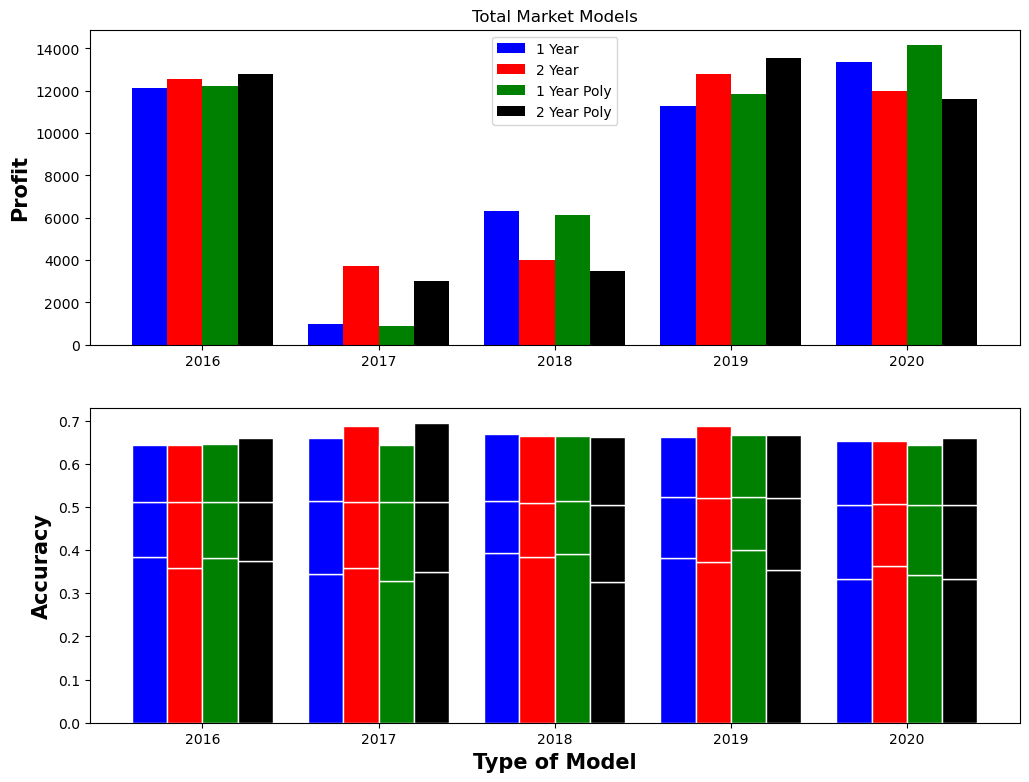

In [55]:
fig, ax = plt.subplots(2, figsize = (12,9))
br1 = np.arange(len(years)) 
br2 = [x + .2 for x in br1] 
br3 = [x + .2 for x in br2]
br4 = [x + .2 for x in br3]
ax[0].bar(br1, tm_profits, color ='blue', width = 0.2, label="1 Year")
ax[0].bar(br2, tm2_profits, color ='red', width = 0.2, label="2 Year")
ax[0].bar(br3, poly_tm_profits, color ='green', width = 0.2, label="1 Year Poly")
ax[0].bar(br4, poly_tm2_profits, color ='black', width = 0.2, label="2 Year Poly")
ax[0].set_title("Total Market Models")
ax[0].set_ylabel('Profit', fontweight ='bold', fontsize = 15) 
ax[0].set_xticks([r + .3 for r in range(len(years))], ['2016', '2017', '2018', '2019', '2020'])
ax[0].legend()

ax[1].bar(br1, tm_min_accuracies, edgecolor="white", color ='blue', width=.2, label="1 Year")
ax[1].bar(br1, [a_i - b_i for a_i, b_i in zip(tm_mean_accuracies, tm_min_accuracies)], color ='blue', edgecolor="white", width=.2, bottom=tm_min_accuracies)
ax[1].bar(br1, [a_i - b_i for a_i, b_i in zip(tm_max_accuracies, tm_mean_accuracies)], color ='blue', edgecolor="white", width=.2, bottom=tm_mean_accuracies)
ax[1].bar(br2, tm2_min_accuracies, edgecolor="white", color ='red', width=.2, label="2 Year")
ax[1].bar(br2, [a_i - b_i for a_i, b_i in zip(tm2_mean_accuracies, tm2_min_accuracies)], color ='red', edgecolor="white", width=.2, bottom=tm2_min_accuracies)
ax[1].bar(br2, [a_i - b_i for a_i, b_i in zip(tm2_max_accuracies, tm2_mean_accuracies)], color ='red', edgecolor="white", width=.2, bottom=tm2_mean_accuracies)
ax[1].bar(br3, poly_tm_min_accuracies, edgecolor="white", color ='green', width=.2, label="1 Year Poly")
ax[1].bar(br3, [a_i - b_i for a_i, b_i in zip(poly_tm_mean_accuracies, poly_tm_min_accuracies)], color ='green', edgecolor="white", width=.2, bottom=poly_tm_min_accuracies)
ax[1].bar(br3, [a_i - b_i for a_i, b_i in zip(poly_tm_max_accuracies, poly_tm_mean_accuracies)], color ='green', edgecolor="white", width=.2, bottom=poly_tm_mean_accuracies)
ax[1].bar(br4, poly_tm2_min_accuracies, edgecolor="white", color ='black', width=.2, label="2 Year Poly")
ax[1].bar(br4, [a_i - b_i for a_i, b_i in zip(poly_tm2_mean_accuracies, poly_tm2_min_accuracies)], color ='black', edgecolor="white", width=.2, bottom=poly_tm2_min_accuracies)
ax[1].bar(br4, [a_i - b_i for a_i, b_i in zip(poly_tm2_max_accuracies, poly_tm2_mean_accuracies)], color ='black', edgecolor="white", width=.2, bottom=poly_tm2_mean_accuracies)

ax[1].set_xlabel('Type of Model', fontweight ='bold', fontsize = 15)
ax[1].set_ylabel('Accuracy', fontweight ='bold', fontsize = 15) 
ax[1].set_xticks([r + .3 for r in range(len(years))], ['2016', '2017', '2018', '2019', '2020'])
plt.show() 

I will discuss more general trends across all models later in the blog post. For now we will make some preliminary observations about the Total Market Model. Our Total Market Model made considerable profit most years we tested the data on. Both 2017 and 2018 were considerably worse years than the rest with former being worse than the latter. For most of the years it seems like our polynomial feature mapping improves the one year variation, yet fails to show consistent improvement for our two year variation. At this point it is difficult to see a very strong correlation between the modals accuracy and its profit.

<font size="5"> Low Volatility Market Model: <font>

In [ ]:
training_starts = [20150101,20160101,20170101,20180101,20190101]
training_ends = [20160101,20170101,20180101,20190101,20200101]
testing_starts = [20160101,20170101,20180101,20190101,20200101]
testing_ends = [20170101,20180101,20190101,20200101,20210101]
years = [2016,2017,2018,2019,2020]

lv_profits = []
lv_mean_accuracies = []
lv_max_accuracies = []
lv_min_accuracies = []
lv2_profits = []
lv2_mean_accuracies = []
lv2_max_accuracies = []
lv2_min_accuracies = []
poly_lv_profits = []
poly_lv_mean_accuracies = []
poly_lv_max_accuracies = []
poly_lv_min_accuracies = []
poly_lv2_profits = []
poly_lv2_mean_accuracies = []
poly_lv2_max_accuracies = []
poly_lv2_min_accuracies = []

for i in range(len(training_starts)):
    poly_profit2,poly_mean_accuracy2, poly_max_accuracy2, poly_min_accuracy2 = stock_prediction_model(training_starts[i]-10000, training_ends[i], testing_starts[i], testing_ends[i], False, False, 2, False)
    poly_lv2_profits.append(poly_profit2)
    poly_lv2_mean_accuracies.append(poly_mean_accuracy2)
    poly_lv2_max_accuracies.append(poly_max_accuracy2)
    poly_lv2_min_accuracies.append(poly_min_accuracy2)
    poly_profit,poly_mean_accuracy, poly_max_accuracy, poly_min_accuracy = stock_prediction_model(training_starts[i], training_ends[i], testing_starts[i], testing_ends[i], False, False, 2, False)
    poly_lv_profits.append(poly_profit)
    poly_lv_mean_accuracies.append(poly_mean_accuracy)
    poly_lv_max_accuracies.append(poly_max_accuracy)
    poly_lv_min_accuracies.append(poly_min_accuracy)
    profit2, mean_accuracy2, max_accuracy2, min_accuracy2 = stock_prediction_model(training_starts[i]-10000, training_ends[i], testing_starts[i], testing_ends[i], False, False, 1, False)
    lv2_profits.append(profit2)
    lv2_mean_accuracies.append(mean_accuracy2)
    lv2_max_accuracies.append(max_accuracy2)
    lv2_min_accuracies.append(min_accuracy2)
    profit, mean_accuracy, max_accuracy, min_accuracy = stock_prediction_model(training_starts[i], training_ends[i], testing_starts[i], testing_ends[i], False, False, 1, False)
    lv_profits.append(profit)
    lv_mean_accuracies.append(mean_accuracy)
    lv_max_accuracies.append(max_accuracy)
    lv_min_accuracies.append(min_accuracy)

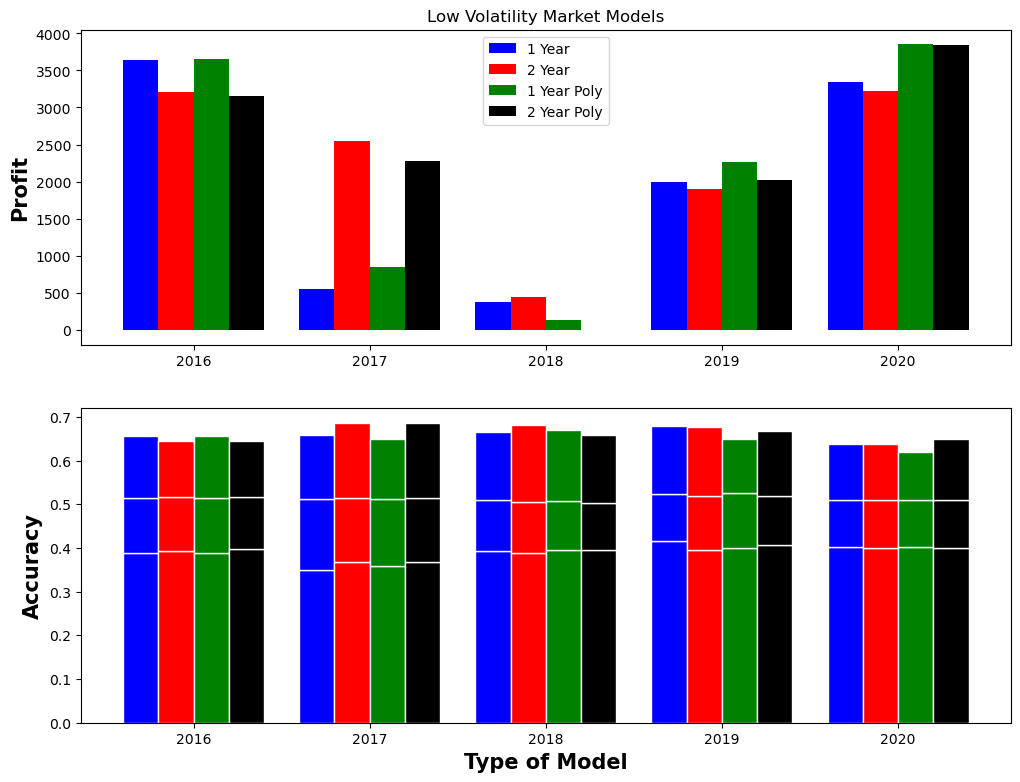

In [54]:
fig, ax = plt.subplots(2, figsize = (12,9))
br1 = np.arange(len(years)) 
br2 = [x + .2 for x in br1] 
br3 = [x + .2 for x in br2]
br4 = [x + .2 for x in br3]
ax[0].bar(br1, lv_profits, color ='blue', width = 0.2, label="1 Year")
ax[0].bar(br2, lv2_profits, color ='red', width = 0.2, label="2 Year")
ax[0].bar(br3, poly_lv_profits, color ='green', width = 0.2, label="1 Year Poly")
ax[0].bar(br4, poly_lv2_profits, color ='black', width = 0.2, label="2 Year Poly")
ax[0].set_title("Low Volatility Market Models")
ax[0].set_ylabel('Profit', fontweight ='bold', fontsize = 15) 
ax[0].set_xticks([r + .3 for r in range(len(years))], ['2016', '2017', '2018', '2019', '2020'])
ax[0].legend()

ax[1].bar(br1, lv_min_accuracies, edgecolor="white", color ='blue', width=.2, label="1 Year")
ax[1].bar(br1, [a_i - b_i for a_i, b_i in zip(lv_mean_accuracies, lv_min_accuracies)], color ='blue', edgecolor="white", width=.2, bottom=lv_min_accuracies)
ax[1].bar(br1, [a_i - b_i for a_i, b_i in zip(lv_max_accuracies, lv_mean_accuracies)], color ='blue', edgecolor="white", width=.2, bottom=lv_mean_accuracies)
ax[1].bar(br2, lv2_min_accuracies, edgecolor="white", color ='red', width=.2, label="2 Year")
ax[1].bar(br2, [a_i - b_i for a_i, b_i in zip(lv2_mean_accuracies, lv2_min_accuracies)], color ='red', edgecolor="white", width=.2, bottom=lv2_min_accuracies)
ax[1].bar(br2, [a_i - b_i for a_i, b_i in zip(lv2_max_accuracies, lv2_mean_accuracies)], color ='red', edgecolor="white", width=.2, bottom=lv2_mean_accuracies)
ax[1].bar(br3, poly_lv_min_accuracies, edgecolor="white", color ='green', width=.2, label="1 Year Poly")
ax[1].bar(br3, [a_i - b_i for a_i, b_i in zip(poly_lv_mean_accuracies, poly_lv_min_accuracies)], color ='green', edgecolor="white", width=.2, bottom=poly_lv_min_accuracies)
ax[1].bar(br3, [a_i - b_i for a_i, b_i in zip(poly_lv_max_accuracies, poly_lv_mean_accuracies)], color ='green', edgecolor="white", width=.2, bottom=poly_lv_mean_accuracies)
ax[1].bar(br4, poly_lv2_min_accuracies, edgecolor="white", color ='black', width=.2, label="2 Year Poly")
ax[1].bar(br4, [a_i - b_i for a_i, b_i in zip(poly_lv2_mean_accuracies, poly_lv2_min_accuracies)], color ='black', edgecolor="white", width=.2, bottom=poly_lv2_min_accuracies)
ax[1].bar(br4, [a_i - b_i for a_i, b_i in zip(poly_lv2_max_accuracies, poly_lv2_mean_accuracies)], color ='black', edgecolor="white", width=.2, bottom=poly_lv2_mean_accuracies)

ax[1].set_xlabel('Type of Model', fontweight ='bold', fontsize = 15)
ax[1].set_ylabel('Accuracy', fontweight ='bold', fontsize = 15) 
ax[1].set_xticks([r + .3 for r in range(len(years))], ['2016', '2017', '2018', '2019', '2020'])
plt.show() 

The low volatility market models are trained and tested on only a third of our companies so it is expected that the profits made will be close to a third of the entire market. However, since these companies are in the bottom third of volatility there price movement will be smaller, so we can assume our models will make slightly less than one third. So, what stands out in this model is how successful we are in 2017 compared to the total market model. Across all variations it seems like we are almost matching the profit of the total market model. The only year that does not look promising is 2018. But, other than that, all of the years seem like they are representative of what they should be.

<font size="5"> Total Market w/ Individual Models Per Company: <font>

In [ ]:
training_starts = [20150101,20160101,20170101,20180101,20190101]
training_ends = [20160101,20170101,20180101,20190101,20200101]
testing_starts = [20160101,20170101,20180101,20190101,20200101]
testing_ends = [20170101,20180101,20190101,20200101,20210101]
years = [2016,2017,2018,2019,2020]

tmi_profits = []
tmi_mean_accuracies = []
tmi_max_accuracies = []
tmi_min_accuracies = []
tmi2_profits = []
tmi2_mean_accuracies = []
tmi2_max_accuracies = []
tmi2_min_accuracies = []
poly_tmi_profits = []
poly_tmi_mean_accuracies = []
poly_tmi_max_accuracies = []
poly_tmi_min_accuracies = []
poly_tmi2_profits = []
poly_tmi2_mean_accuracies = []
poly_tmi2_max_accuracies = []
poly_tmi2_min_accuracies = []

for i in range(len(training_starts)):
    poly_profit2,poly_mean_accuracy2, poly_max_accuracy2, poly_min_accuracy2 = stock_prediction_model(training_starts[i]-10000, training_ends[i], testing_starts[i], testing_ends[i], True, True, 2, False)
    poly_tmi2_profits.append(poly_profit2)
    poly_tmi2_mean_accuracies.append(poly_mean_accuracy2)
    poly_tmi2_max_accuracies.append(poly_max_accuracy2)
    poly_tmi2_min_accuracies.append(poly_min_accuracy2)
    poly_profit,poly_mean_accuracy, poly_max_accuracy, poly_min_accuracy = stock_prediction_model(training_starts[i], training_ends[i], testing_starts[i], testing_ends[i], True, True, 2, False)
    poly_tmi_profits.append(poly_profit)
    poly_tmi_mean_accuracies.append(poly_mean_accuracy)
    poly_tmi_max_accuracies.append(poly_max_accuracy)
    poly_tmi_min_accuracies.append(poly_min_accuracy)
    profit2, mean_accuracy2, max_accuracy2, min_accuracy2 = stock_prediction_model(training_starts[i]-10000, training_ends[i], testing_starts[i], testing_ends[i], True, True, 1, False)
    tmi2_profits.append(profit2)
    tmi2_mean_accuracies.append(mean_accuracy2)
    tmi2_max_accuracies.append(max_accuracy2)
    tmi2_min_accuracies.append(min_accuracy2)
    profit, mean_accuracy, max_accuracy, min_accuracy = stock_prediction_model(training_starts[i], training_ends[i], testing_starts[i], testing_ends[i], True, True, 1, False)
    tmi_profits.append(profit)
    tmi_mean_accuracies.append(mean_accuracy)
    tmi_max_accuracies.append(max_accuracy)
    tmi_min_accuracies.append(min_accuracy)

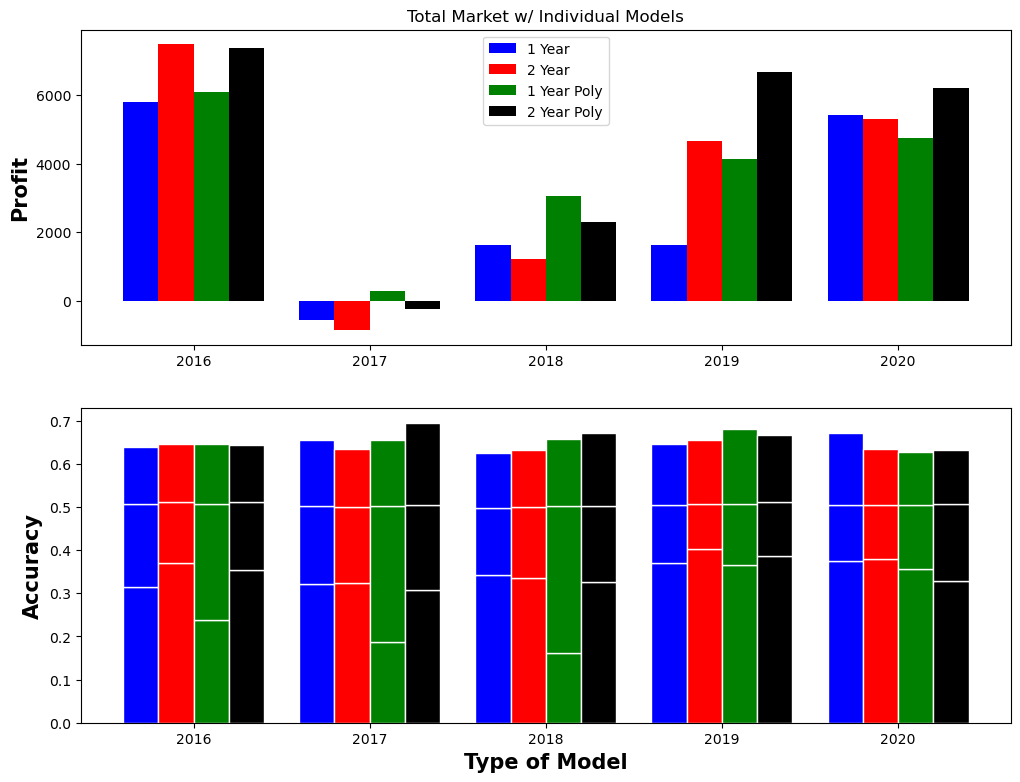

In [52]:
fig, ax = plt.subplots(2, figsize = (12,9))
br1 = np.arange(len(years)) 
br2 = [x + .2 for x in br1] 
br3 = [x + .2 for x in br2]
br4 = [x + .2 for x in br3]
ax[0].bar(br1, tmi_profits, color ='blue', width = 0.2, label="1 Year")
ax[0].bar(br2, tmi2_profits, color ='red', width = 0.2, label="2 Year")
ax[0].bar(br3, poly_tmi_profits, color ='green', width = 0.2, label="1 Year Poly")
ax[0].bar(br4, poly_tmi2_profits, color ='black', width = 0.2, label="2 Year Poly")
ax[0].set_title("Total Market w/ Individual Models")
ax[0].set_ylabel('Profit', fontweight ='bold', fontsize = 15) 
ax[0].set_xticks([r + .3 for r in range(len(years))], ['2016', '2017', '2018', '2019', '2020'])
ax[0].legend()

ax[1].bar(br1, tmi_min_accuracies, edgecolor="white", color ='blue', width=.2, label="1 Year")
ax[1].bar(br1, [a_i - b_i for a_i, b_i in zip(tmi_mean_accuracies, tmi_min_accuracies)], color ='blue', edgecolor="white", width=.2, bottom=tmi_min_accuracies)
ax[1].bar(br1, [a_i - b_i for a_i, b_i in zip(tmi_max_accuracies, tmi_mean_accuracies)], color ='blue', edgecolor="white", width=.2, bottom=tmi_mean_accuracies)
ax[1].bar(br2, tmi2_min_accuracies, edgecolor="white", color ='red', width=.2, label="2 Year")
ax[1].bar(br2, [a_i - b_i for a_i, b_i in zip(tmi2_mean_accuracies, tmi2_min_accuracies)], color ='red', edgecolor="white", width=.2, bottom=tmi2_min_accuracies)
ax[1].bar(br2, [a_i - b_i for a_i, b_i in zip(tmi2_max_accuracies, tmi2_mean_accuracies)], color ='red', edgecolor="white", width=.2, bottom=tmi2_mean_accuracies)
ax[1].bar(br3, poly_tmi_min_accuracies, edgecolor="white", color ='green', width=.2, label="1 Year Poly")
ax[1].bar(br3, [a_i - b_i for a_i, b_i in zip(poly_tmi_mean_accuracies, poly_tmi_min_accuracies)], color ='green', edgecolor="white", width=.2, bottom=poly_tmi_min_accuracies)
ax[1].bar(br3, [a_i - b_i for a_i, b_i in zip(poly_tmi_max_accuracies, poly_tmi_mean_accuracies)], color ='green', edgecolor="white", width=.2, bottom=poly_tmi_mean_accuracies)
ax[1].bar(br4, poly_tmi2_min_accuracies, edgecolor="white", color ='black', width=.2, label="2 Year Poly")
ax[1].bar(br4, [a_i - b_i for a_i, b_i in zip(poly_tmi2_mean_accuracies, poly_tmi2_min_accuracies)], color ='black', edgecolor="white", width=.2, bottom=poly_tmi2_min_accuracies)
ax[1].bar(br4, [a_i - b_i for a_i, b_i in zip(poly_tmi2_max_accuracies, poly_tmi2_mean_accuracies)], color ='black', edgecolor="white", width=.2, bottom=poly_tmi2_mean_accuracies)

ax[1].set_xlabel('Type of Model', fontweight ='bold', fontsize = 15)
ax[1].set_ylabel('Accuracy', fontweight ='bold', fontsize = 15) 
ax[1].set_xticks([r + .3 for r in range(len(years))], ['2016', '2017', '2018', '2019', '2020'])
plt.show() 

Our total market w/ independent models does not live up to the expectations we expressed in our hypotheses. Compared to a single model the individual models makes considerably less money. It's performance in 2017 is the worst we have seen yet. One of the questions that we begin to have is "why do we lose so much money if we have such a considerably normal mean accuracy?" The simple answer is that the market was rather turbulent in 2017 and the price movement was larger, on average, when we made an incorrect guess, than when we made a correct guess. Another thing to note, is that since we are training a model for each company, there are considerably less data points to train on. In fact, when training on one year of data, a single company only has around 240 data points, while the total market model has over one 1,000,000. I suspect this is the main contributor to why our individual models do so much more poorly than the total market model. I also think that the size of the training data is why, when we use polynomial feature mapping and more years of training data, our profit is noticeably higher.

<font size="5"> Low Volatility w/ Individual Models Per Company: <font>

In [ ]:
training_starts = [20150101,20160101,20170101,20180101,20190101]
training_ends = [20160101,20170101,20180101,20190101,20200101]
testing_starts = [20160101,20170101,20180101,20190101,20200101]
testing_ends = [20170101,20180101,20190101,20200101,20210101]
years = [2016,2017,2018,2019,2020]

lvi_profits = []
lvi_mean_accuracies = []
lvi_max_accuracies = []
lvi_min_accuracies = []
lvi2_profits = []
lvi2_mean_accuracies = []
lvi2_max_accuracies = []
lvi2_min_accuracies = []
poly_lvi_profits = []
poly_lvi_mean_accuracies = []
poly_lvi_max_accuracies = []
poly_lvi_min_accuracies = []
poly_lvi2_profits = []
poly_lvi2_mean_accuracies = []
poly_lvi2_max_accuracies = []
poly_lvi2_min_accuracies = []

for i in range(len(training_starts)):
    poly_profit2,poly_mean_accuracy2, poly_max_accuracy2, poly_min_accuracy2 = stock_prediction_model(training_starts[i]-10000, training_ends[i], testing_starts[i], testing_ends[i], False, True, 2, False)
    poly_lvi2_profits.append(poly_profit2)
    poly_lvi2_mean_accuracies.append(poly_mean_accuracy2)
    poly_lvi2_max_accuracies.append(poly_max_accuracy2)
    poly_lvi2_min_accuracies.append(poly_min_accuracy2)
    poly_profit,poly_mean_accuracy, poly_max_accuracy, poly_min_accuracy = stock_prediction_model(training_starts[i], training_ends[i], testing_starts[i], testing_ends[i], False, True, 2, False)
    poly_lvi_profits.append(poly_profit)
    poly_lvi_mean_accuracies.append(poly_mean_accuracy)
    poly_lvi_max_accuracies.append(poly_max_accuracy)
    poly_lvi_min_accuracies.append(poly_min_accuracy)
    profit2, mean_accuracy2, max_accuracy2, min_accuracy2 = stock_prediction_model(training_starts[i]-10000, training_ends[i], testing_starts[i], testing_ends[i], False, True, 1, False)
    lvi2_profits.append(profit2)
    lvi2_mean_accuracies.append(mean_accuracy2)
    lvi2_max_accuracies.append(max_accuracy2)
    lvi2_min_accuracies.append(min_accuracy2)
    profit, mean_accuracy, max_accuracy, min_accuracy = stock_prediction_model(training_starts[i], training_ends[i], testing_starts[i], testing_ends[i], False, True, 1, False)
    lvi_profits.append(profit)
    lvi_mean_accuracies.append(mean_accuracy)
    lvi_max_accuracies.append(max_accuracy)
    lvi_min_accuracies.append(min_accuracy)

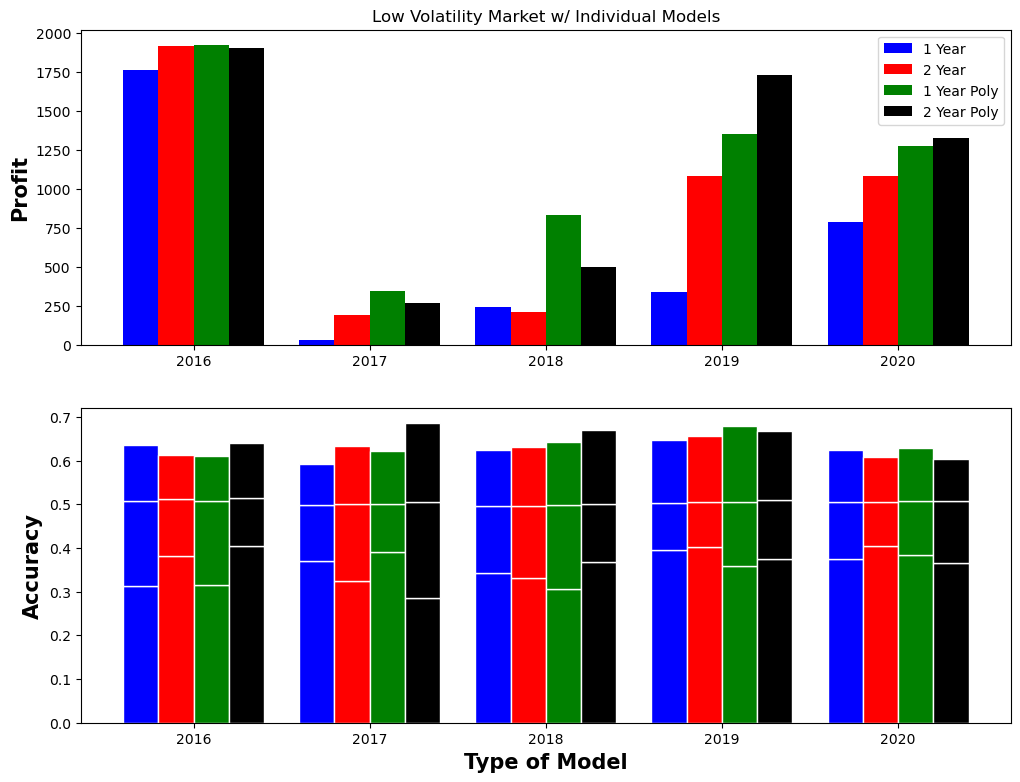

In [53]:
fig, ax = plt.subplots(2, figsize = (12,9))
br1 = np.arange(len(years)) 
br2 = [x + .2 for x in br1] 
br3 = [x + .2 for x in br2]
br4 = [x + .2 for x in br3]
ax[0].bar(br1, lvi_profits, color ='blue', width = 0.2, label="1 Year")
ax[0].bar(br2, lvi2_profits, color ='red', width = 0.2, label="2 Year")
ax[0].bar(br3, poly_lvi_profits, color ='green', width = 0.2, label="1 Year Poly")
ax[0].bar(br4, poly_lvi2_profits, color ='black', width = 0.2, label="2 Year Poly")
ax[0].set_title("Low Volatility Market w/ Individual Models")
ax[0].set_ylabel('Profit', fontweight ='bold', fontsize = 15) 
ax[0].set_xticks([r + .3 for r in range(len(years))], ['2016', '2017', '2018', '2019', '2020'])
ax[0].legend()

ax[1].bar(br1, lvi_min_accuracies, edgecolor="white", color ='blue', width=.2, label="1 Year")
ax[1].bar(br1, [a_i - b_i for a_i, b_i in zip(lvi_mean_accuracies, lvi_min_accuracies)], color ='blue', edgecolor="white", width=.2, bottom=lvi_min_accuracies)
ax[1].bar(br1, [a_i - b_i for a_i, b_i in zip(lvi_max_accuracies, lvi_mean_accuracies)], color ='blue', edgecolor="white", width=.2, bottom=lvi_mean_accuracies)
ax[1].bar(br2, lvi2_min_accuracies, edgecolor="white", color ='red', width=.2, label="2 Year")
ax[1].bar(br2, [a_i - b_i for a_i, b_i in zip(lvi2_mean_accuracies, lvi2_min_accuracies)], color ='red', edgecolor="white", width=.2, bottom=lvi2_min_accuracies)
ax[1].bar(br2, [a_i - b_i for a_i, b_i in zip(lvi2_max_accuracies, lvi2_mean_accuracies)], color ='red', edgecolor="white", width=.2, bottom=lvi2_mean_accuracies)
ax[1].bar(br3, poly_lvi_min_accuracies, edgecolor="white", color ='green', width=.2, label="1 Year Poly")
ax[1].bar(br3, [a_i - b_i for a_i, b_i in zip(poly_lvi_mean_accuracies, poly_lvi_min_accuracies)], color ='green', edgecolor="white", width=.2, bottom=poly_lvi_min_accuracies)
ax[1].bar(br3, [a_i - b_i for a_i, b_i in zip(poly_lvi_max_accuracies, poly_lvi_mean_accuracies)], color ='green', edgecolor="white", width=.2, bottom=poly_lvi_mean_accuracies)
ax[1].bar(br4, poly_lvi2_min_accuracies, edgecolor="white", color ='black', width=.2, label="2 Year Poly")
ax[1].bar(br4, [a_i - b_i for a_i, b_i in zip(poly_lvi2_mean_accuracies, poly_lvi2_min_accuracies)], color ='black', edgecolor="white", width=.2, bottom=poly_lvi2_min_accuracies)
ax[1].bar(br4, [a_i - b_i for a_i, b_i in zip(poly_lvi2_max_accuracies, poly_lvi2_mean_accuracies)], color ='black', edgecolor="white", width=.2, bottom=poly_lvi2_mean_accuracies)

ax[1].set_xlabel('Type of Model', fontweight ='bold', fontsize = 15)
ax[1].set_ylabel('Accuracy', fontweight ='bold', fontsize = 15) 
ax[1].set_xticks([r + .3 for r in range(len(years))], ['2016', '2017', '2018', '2019', '2020'])
plt.show() 

Everything discussed about the Total Market w/ Individual Models with respect to more data equals better results seems to be exemplified here. Maybe the trend is easier to see because we are only testing on low volatility stocks, but as 2 year has more data than 1 year, 1 year poly has more data than 2 year, 2 year poly has more data than 1 year poly, and our profit increase across all years roughly in that order. While the profit for this model is not as impressive as the other models, it has some of the most consistent results across variations.

<font size="5"> Trends Across Models: <font>

<font size="6"> Conclusion: <font>

